# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices

Welcome to the first project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started
In this project, you will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [31]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis=1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, you will make a cursory investigation about the Boston housing data and provide your observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
For your very first coding implementation, you will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for you, use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, you will need to implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

In [32]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data, considering the dataset
# as a sample of the population and applying the Bessel's correction
std_price = np.std(prices, ddof=1)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,340.28


### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

_Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each._  
**Hint:** Would you expect a home that has an `'RM'` value of 6 be worth more or less than a home that has an `'RM'` value of 7?

**Answer: ** An increase in the value of the 'RM' feature would increase the value of 'MEDV', since bigger homes tend to be more expensive and an increase in the average number of rooms would shift the whole price distribution toward higher prices, thus increasing the median of that distribution. It's also fair to consider that the number of rooms among houses in the same neighborhood is not drastically different.

An increase in the value of the 'LSTAT' feature means a decrease in the average buying power of homeowners in a neighborhood. Thus the homeowners would be able to afford less expensive homes and the value of 'MEDV' would decrease.

A low student/teacher ratio is correlated with a high quality of education, which is a characteristic that adds value to a neighborhood. Therefore, an increase in the value of the 'PTRATIO' feature would go in the opposite direction, decreasing the value of 'MEDV'.

----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, you will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [33]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |
*Would you consider this model to have successfully captured the variation of the target variable? Why or why not?* 

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

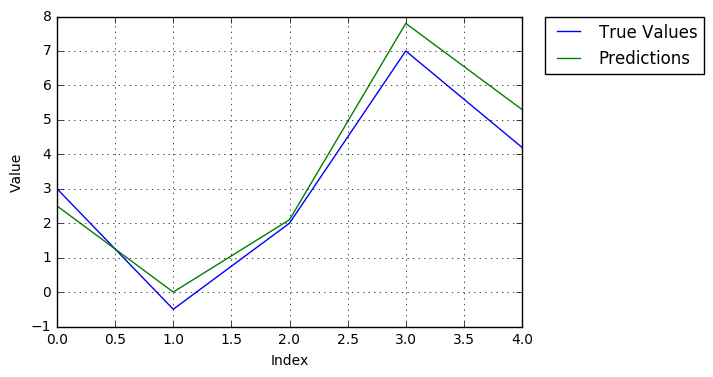

Mean of residuals is 0.4


In [34]:
# Performing a quick check on the residuals
import matplotlib.pyplot as plt

plt.plot([3, -0.5, 2, 7, 4.2])
plt.plot([2.5, 0.0, 2.1, 7.8, 5.3])
plt.legend(['True Values','Predictions'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.grid(True)
plt.xlabel('Index'), plt.ylabel('Value')
plt.show()

print "Mean of residuals is {}".format(np.mean(np.array([2.5, 0.0, 2.1, 7.8, 5.3]) - np.array([3, -0.5, 2, 7, 4.2])))

In [35]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print u"Model has a coefficient of determination, R\u00B2, of {:.3f}.".format(score)

Model has a coefficient of determination, R², of 0.923.


**Answer:** Yes, although there are some relatively high residuals and their mean is not so small, the variation of the prediction follows the variation of the target variable to a great extent. Observing the value of the R<sup>2</sup> coefficient we could say that the model can explain about 92% of the target variable. According to this post (http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit) it's a good idea to evaluate the R<sup>2</sup> coefficient in conjunction with the residuals. The author shows how a large value of R<sup>2</sup> may be associated with a bad fit.

### Implementation: Shuffle and Split Data
Your next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, you will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [36]:
# Import 'train_test_split'
from sklearn.cross_validation import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


### Question 3 - Training and Testing
*What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?*  
**Hint:** What could go wrong with not having a way to test your model?

**Answer: ** Splitting a dataset into training and testing subsets allows us to evaluate the performance of an algorithm on unseen data and avoid overfitting. An overly complex model trained with all available data would overfit, performing really well during training but poorly in production. The train/test split allows us to check how well a model generalizes as a function of its complexity/parameters, helping us to improve its generalization capacity and achieve a consistent performance.

----

## Analyzing Model Performance
In this third section of the project, you'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

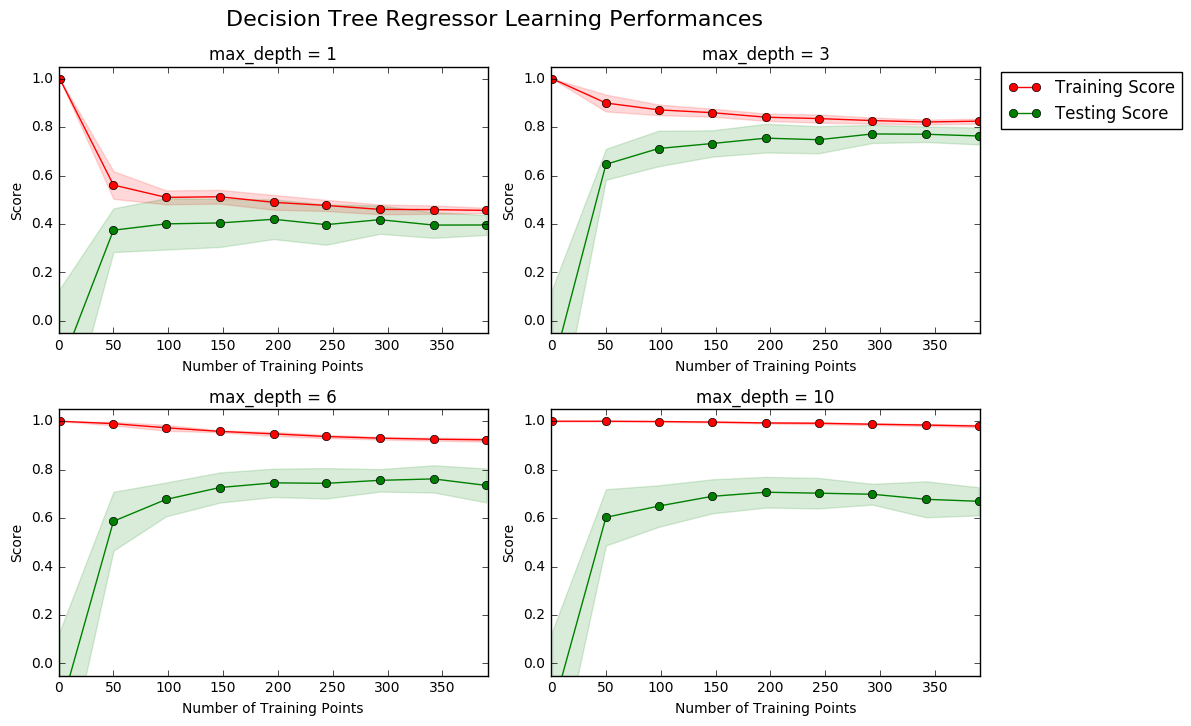

In [37]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4 - Learning the Data
*Choose one of the graphs above and state the maximum depth for the model. What happens to the score of the training curve as more training points are added? What about the testing curve? Would having more training points benefit the model?*  
**Hint:** Are the learning curves converging to particular scores?

**Answer: ** In the graph with <code>max_depth = 3</code> the score of the training curve stabilizes slightly above 80% and the addition of more training data doesn't improve the score. Regarding the testing curve, its score seems to decrease slowly with the addition of more training data. Therefore, having more training points wouldn't benefit the model. The best performance occurs between 300 and 350 training points, where the training and testing curves are closer and the uncertainty of the testing curve is very small. Observing the gap between the curves, this model shows much less overfitting than the models with <code>max_depth = 6</code> and <code>max_depth = 10</code>. It also has a better performance than the model with <code>max_depth = 1</code> and, among the four models, achieves the better compromise between bias and overfitting.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

Run the code cell below and use this graph to answer the following two questions.

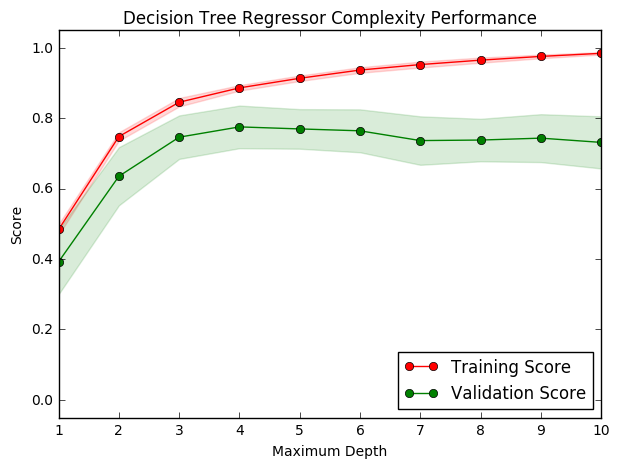

In [38]:
vs.ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
*When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?*  
**Hint:** How do you know when a model is suffering from high bias or high variance?

**Answer: ** When trained with a maximum depth of 1 the model suffers from high bias, since the training and testing scores are small and close to each other (0.5 and 0.4, respectively). In this case the model isn't complex enough to accurately describe the data. When trained with maximum depth of 10 the model suffers from high variance, because the training score is close to 1.0 but the testing score is much worse (about 0.73). In this case the model is overly complex, it tries to describe relationships in the data that actually don't exist and does not generalize well.

### Question 6 - Best-Guess Optimal Model
*Which maximum depth do you think results in a model that best generalizes to unseen data? What intuition lead you to this answer?*

**Answer: ** The model that best generalizes to unseen data has a maximum depth of 4. That's because up to depth 4 an increase in training performance is associated with an increase in testing performance. That means that what the model learns from the training data is improving its performance on unseen data, in other words, its generalization capacity is increasing with its complexity. For depths greater than 4 an increase in complexity improves training performance but testing performance shows a decreasing trend. In this case a more complex model is not extracting more useful information from the training data.

-----

## Evaluating Model Performance
In this final section of the project, you will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
*What is the grid search technique and how it can be applied to optimize a learning algorithm?*

**Answer: ** The grid search technique consists in searching for the values of a set of predefined parameters that characterize the estimator with the best performance. Each parameter represents a dimension of the parameter grid, and each dimension has some predefined set of values. The technique can be applied to discover the parameter setting that results in the best performance among a set of parameter settings. For example, if we have an estimator that requires some parameters to be fully described (as is often the case), we can select some acceptable values for each parameter and use the grid search technique in order to get the combination of values that define the estimator with the best performance. The performance is usually evaluated by cross-validation.

### Question 8 - Cross-Validation
*What is the k-fold cross-validation training technique? What benefit does this technique provide for grid search when optimizing a model?*  
**Hint:** Much like the reasoning behind having a testing set, what could go wrong with using grid search without a cross-validated set?

**Answer: ** In the k-fold cross-validation technique we split our data into k slices and proceed to k train/test iterations. In each iteration one of the slices is used for testing and the others for training, so that each slice is used for testing one time and for training (k - 1) times. The final performance is then the average of the performances for each iteration.

With cross-validation the performance of a model with a particular parameter setting is representative of the whole data. That's important because the data may be skewed with respect to how it is indexed, an using the same train/test partitioning may favor a parameter setting that performs great on that specific splitting but does not generalize well to the whole data. Cross-validation helps us avoid this problem.

### Implementation: Fitting a Model
Your final implementation requires that you bring everything together and train a model using the **decision tree algorithm**. To ensure that you are producing an optimized model, you will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, you will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique you describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_iter'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [39]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV


def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.20, random_state=0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model
_What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?_  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [40]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.


**Answer: ** The optimal model has a maximum depth of 4 and my guess happened to be right. Actually the code that generates the complexity curves is almost identical to the code above. The most important difference is that the grid search makes explicit the estimator with the best average performance on unseen data.

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  
**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  

Run the code block below to have your optimized model make predictions for each client's home.

In [41]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
predictions = reg.predict(client_data)
for i, price in enumerate(predictions):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

# Statistics from the Data Exploration section
print "\n\nStatistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Predicted selling price for Client 1's home: $391,183.33
Predicted selling price for Client 2's home: $189,123.53
Predicted selling price for Client 3's home: $942,666.67


Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,340.28


**Answer: ** Based on the results above I would recommend \$392,000 to client 1, \$190,000 to client 2 and \$943,000 to client 3. The prices seem reasonable because i) the first and second prices are within the mean plus or minus 2 standard deviations, ii) the third price is outside that interval but the price is justified by the features (high number of rooms, extremely low neighborhood proverty level and an excellent student to teacher ratio in nearby schools), iii) from client 1 to client 2 all features change in the direction that suggests lower prices and the model correctly reflects that.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [42]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Question 11 - Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

**Answer: ** The constructed model should not be used in a real-world setting, but it could certainly be improved in order to do so.

Although the prices were scaled to account for inflation, other factors that change with time can influence the price. According to this source (http://www.zillow.com/boston-ma/home-values/) at the time of writing, the median home value in Boston is \$505,100 and the median listing price is \$629,000. Both values are above the calculated median price.

The features present in the data are indeed important but not sufficient to describe a home. Other amenities like a gym or a swimming pool, proximity to hospitals, schools, supermarkets or public infrastructure add significant value to a home.

Observing the results of <code>PredictTrials</code> I would say that the model is not robust enough to make consistent predictions as they differ by up to \$69,000. Supposing a price of \$400,000 that amount represents more than 17% of the price, while Boston home values have gone up 8.2% over the past year according to the source above.

Data collected in an urban city would not de applicable in a rural city because location plays a key role in evaluating a property and the features that drive the price in rural areas may be different than those in urban areas.

To be useful in a real-world setting more recent data would have to be collected and the importance of each feature should be evaluated.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.